In [4]:
import pandas as pd

In [5]:

import numpy as np


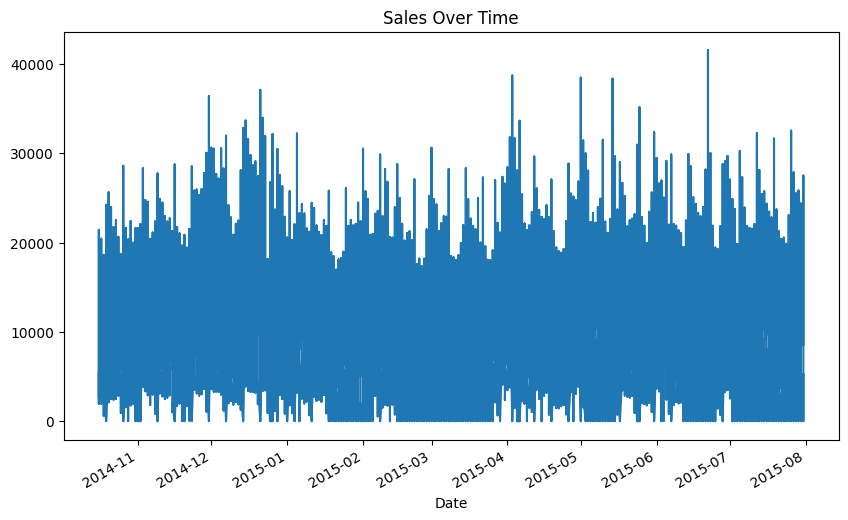

In [6]:
# Load the dataset into a pandas DataFrame
data = pd.read_csv('train.csv')

# Check the first few rows
data.head()

# Convert 'Date' column to datetime format and set it as index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Sort the data by date
data = data.sort_index()

# Keep only the 'Sales' column for simplicity
data = data[['Sales']]

# Visualize the sales data (optional)
import matplotlib.pyplot as plt
data['Sales'].plot(figsize=(10, 6))
plt.title('Sales Over Time')
plt.show()

In [8]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Assuming 'data' is your DataFrame
data['Sales'] = pd.to_numeric(data['Sales'], errors='coerce')  # Convert to numeric

# Check for missing values
print("Missing values in 'Sales':", data['Sales'].isnull().sum())

# Optionally fill or drop missing values
data.dropna(inplace=True)  # Drop missing values, or use fillna as needed

# Recheck the data
print(data.head())

# Perform ADF test
result = adfuller(data['Sales'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

if result[1] < 0.05:
    print('The time series is stationary.')
else:
    print('The time series is not stationary.')

Missing values in 'Sales': 1
              Sales
Date               
2014-10-16   5378.0
2014-10-16   4165.0
2014-10-16  11600.0
2014-10-16   5833.0
2014-10-16   7326.0
ADF Statistic: -12.683180
p-value: 0.000000
The time series is stationary.


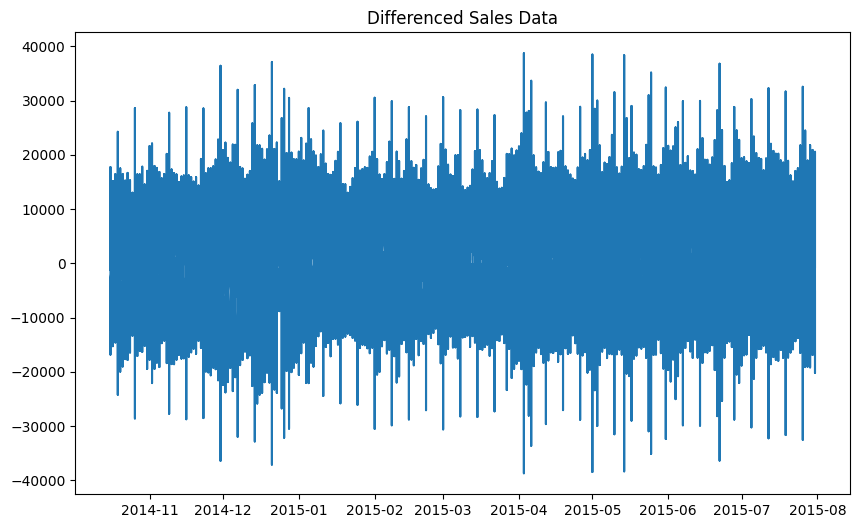

ADF Statistic: -74.418858
p-value: 0.000000
The differenced time series is stationary.


In [10]:
# Apply differencing if the data is not stationary
data_diff = data['Sales'].diff().dropna()

# Plot the differenced data
plt.figure(figsize=(10, 6))
plt.plot(data_diff)
plt.title('Differenced Sales Data')
plt.show()

# Check stationarity again using ADF test
result_diff = adfuller(data_diff)

print('ADF Statistic: %f' % result_diff[0])
print('p-value: %f' % result_diff[1])

if result_diff[1] < 0.05:
    print('The differenced time series is stationary.')
else:
    print('The time series is still not stationary.')


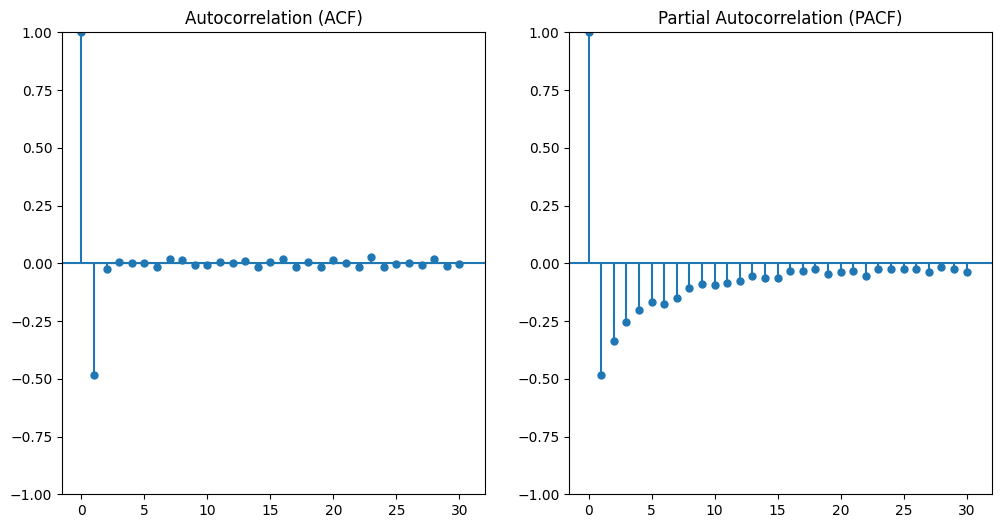

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
plt.figure(figsize=(12,6))

plt.subplot(121)
plot_acf(data_diff, ax=plt.gca(), lags=30)
plt.title('Autocorrelation (ACF)')

plt.subplot(122)
plot_pacf(data_diff, ax=plt.gca(), lags=30)
plt.title('Partial Autocorrelation (PACF)')

plt.show()


In [21]:
def create_supervised_data(series, look_back=1):
    X, y = [], []
    for i in range(len(series) - look_back):
        X.append(series[i:(i+look_back)])
        y.append(series[i + look_back])
    return np.array(X), np.array(y)

# Use look_back=7 to look at the last 7 days' sales to predict the next day
look_back = 30
X, y = create_supervised_data(data_diff.values, look_back)

print('X shape:', X.shape)
print('y shape:', y.shape)


X shape: (308187, 30)
y shape: (308187,)


In [22]:
from sklearn.preprocessing import MinMaxScaler

# Scale X and y
scaler_X = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

print('X_scaled shape:', X_scaled.shape)
print('y_scaled shape:', y_scaled.shape)


X_scaled shape: (308187, 30)
y_scaled shape: (308187, 1)


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Reshape X to 3D for LSTM [samples, timesteps, features]
X_scaled = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# Build LSTM Model
model = Sequential()

# First LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_scaled.shape[1], 1)))  # Increased units
model.add(Dropout(0.3))  # Increased dropout for regularization

# Second LSTM layer
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.3))

# Add a Dense layer before the output for better learning
model.add(Dense(50, activation='relu'))

# Output layer for regression (1 unit)
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Add callbacks for learning rate scheduling and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with learning rate scheduler and early stopping
history = model.fit(X_scaled, y_scaled,
                    epochs=50,  # Limit to 50 epochs
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[reduce_lr, early_stop])

Epoch 1/50
7705/7705 ━━━━━━━━━━━━━━━━━━━━ 65s 8ms/step - loss: 0.0054 - val_loss: 0.0046 - learning_rate: 0.0010
Epoch 2/50
7705/7705 ━━━━━━━━━━━━━━━━━━━━ 79s 8ms/step - loss: 0.0050 - val_loss: 0.0045 - learning_rate: 0.0010
Epoch 3/50
7705/7705 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - loss: 0.0049 - val_loss: 0.0045 - learning_rate: 0.0010
Epoch 4/50
7705/7705 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - loss: 0.0049 - val_loss: 0.0044 - learning_rate: 0.0010
Epoch 5/50
7705/7705 ━━━━━━━━━━━━━━━━━━━━ 60s 8ms/step - loss: 0.0049 - val_loss: 0.0044 - learning_rate: 0.0010
Epoch 6/50
7705/7705 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - loss: 0.0049 - val_loss: 0.0043 - learning_rate: 0.0010
Epoch 7/50
7705/7705 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - loss: 0.0048 - val_loss: 0.0043 - learning_rate: 0.0010
Epoch 8/50
7705/7705 ━━━━━━━━━━━━━━━━━━━━ 80s 8ms/step - loss: 0.0047 - val_loss: 0.0042 - learning_rate: 0.0010
Epoch 9/50
7705/7705 ━━━━━━━━━━━━━━━━━━━━ 84s 8ms/step - loss: 0.0047 - val_loss: 0.0041 - learn

9632/9632 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step


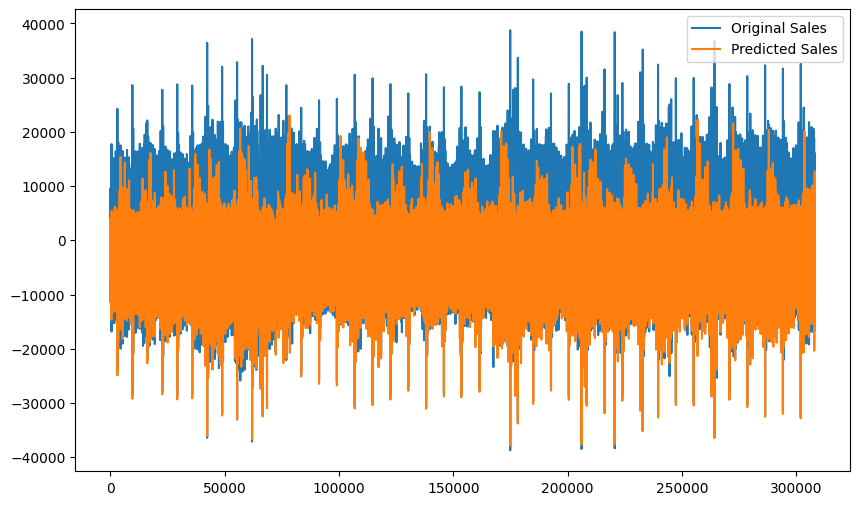

In [19]:
import matplotlib.pyplot as plt

# Predict on the training set (or use separate test set)
y_pred_scaled = model.predict(X_scaled)

# Inverse transform the scaled predictions back to the original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Plot original vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y, label='Original Sales', color='blue')  # Original Sales in blue
plt.plot(y_pred, label='Predicted Sales', color='orange')  # Predicted Sales in orange
plt.title('Original vs Predicted Sales')  # Title of the plot
plt.xlabel('Time/Index')  # Label for the x-axis
plt.ylabel('Sales')  # Label for the y-axis
plt.legend()  # Show legend
plt.show()

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming 'y' is your original sales data and 'model' is your trained LSTM model
# Predict on the training set or a separate test set
y_pred_scaled = model.predict(X_scaled)

# Inverse transform the scaled predictions back to the original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Calculate evaluation metrics
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)  # You can also use mean_squared_error(y, y_pred, squared=False)
r2 = r2_score(y, y_pred)

# Print evaluation metrics
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared (R²): {r2:.2f}')

9632/9632 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step
Mean Absolute Error (MAE): 1736.00
Mean Squared Error (MSE): 6624457.38
Root Mean Squared Error (RMSE): 2573.80
R-squared (R²): 0.51
